In [21]:
from utils import *

import time
import numpy as np

import tensorflow as tf
print(tf.__version__)
import ta

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import decomposition

import xgboost as xgb
from xgboost import plot_importance

pca = decomposition.PCA()

2.2.0-dev20200330


In [22]:
import warnings
warnings.filterwarnings("ignore")
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [23]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/CrudeOil.csv \
    -O /tmp/CrudeOil.csv

--2020-04-02 15:26:54--  https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/CrudeOil.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164137 (160K) [text/plain]
Saving to: ‘/tmp/CrudeOil.csv’

/tmp/CrudeOil.csv   100%[===================>] 160.29K  --.-KB/s    in 0.1s    

2020-04-02 15:26:54 (1.43 MB/s) - ‘/tmp/CrudeOil.csv’ saved [164137/164137]



In [24]:
dataset_ex_df = pd.read_csv('/tmp/CrudeOil.csv', header=0, parse_dates=[0], date_parser=parser)
dataset_ex_df.head()

,Date,Close,Open,High,Low,Volume
0,2020-04-01,20.31,20.10,21.55,19.90,0
1,2020-03-31,20.48,20.23,21.89,20.01,0
2,2020-03-30,20.09,20.93,20.93,19.27,0
3,2020-03-27,21.51,23.29,23.44,20.88,0
4,2020-03-26,22.60,24.25,24.65,22.38,0


In [25]:
# Add all ta features filling nans values
dataset_ex_df = ta.add_all_ta_features(dataset_ex_df, "Open", "High", "Low", "Close","Volume", fillna=True)
for_pca=pd.DataFrame()
for_pca['Date']=dataset_ex_df['Date']
print(for_pca.head())
dataset_ex_df.drop(['Date','Open','High','Low','Volume'],axis=1,inplace=True)

        Date  Close
0 2020-04-01  20.31
1 2020-03-31  20.48
2 2020-03-30  20.09
3 2020-03-27  21.51
4 2020-03-26  22.60


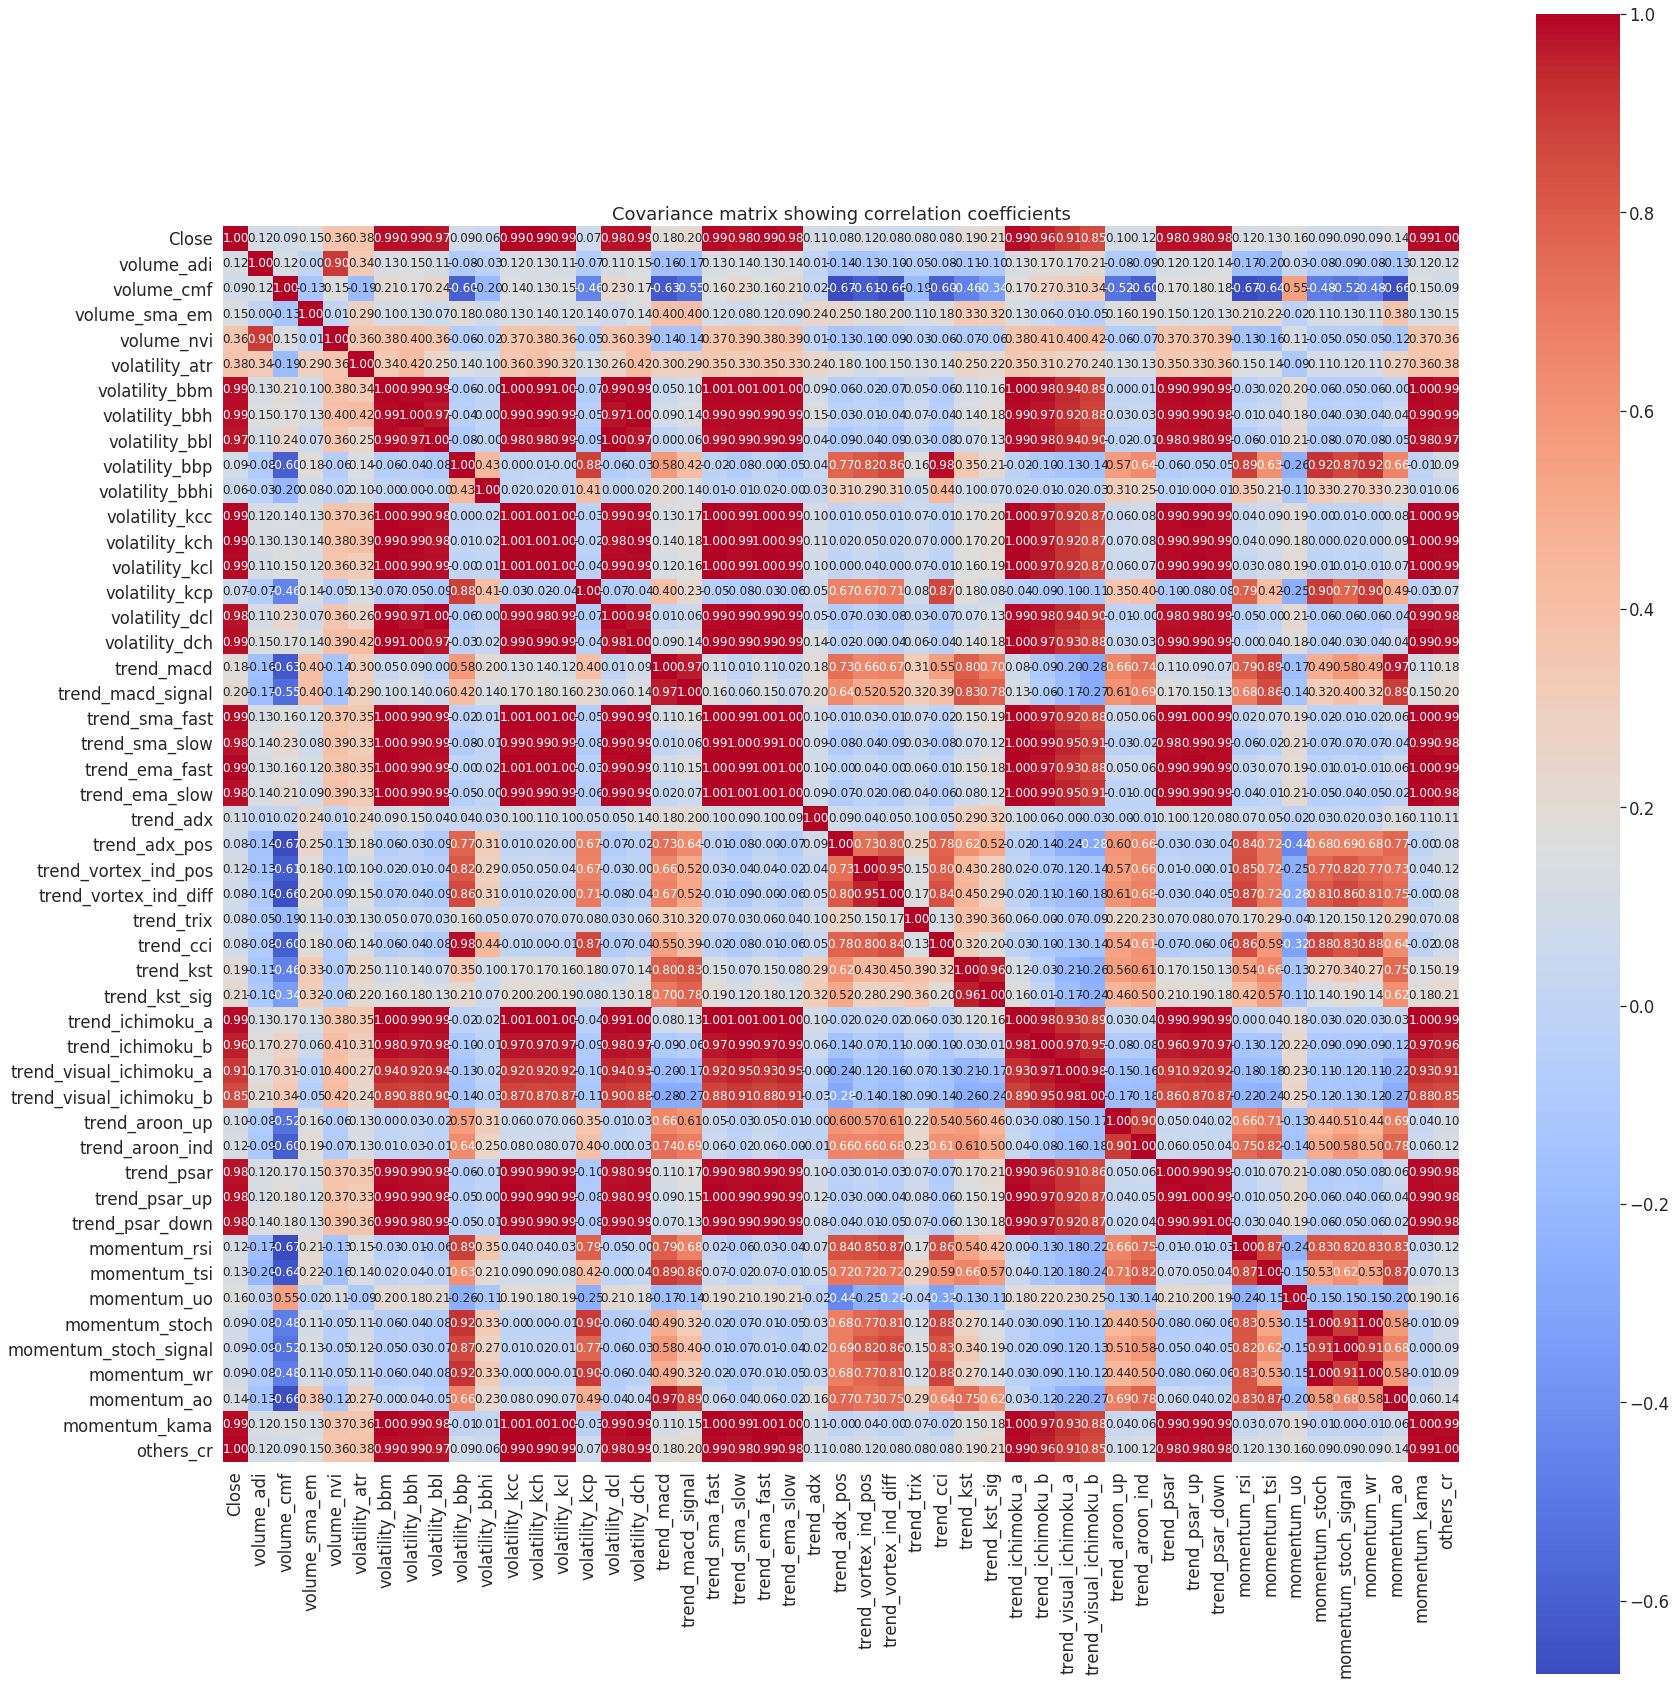

In [61]:
#Standardization
sample_data=dataset_ex_df.fillna(0)
pd.set_option("display.max_rows",None)
standardized_data = StandardScaler().fit_transform(sample_data)
standardized_data = pd.DataFrame(data=standardized_data,columns=sample_data.columns)
for_pca['Close']=standardized_data['Close']

#Computing-Covariance
cov_mat =np.cov(standardized_data.T)
cov_matrix=pd.DataFrame(data=cov_mat,columns=standardized_data.columns,index=standardized_data.columns)
cov_matrix.to_csv('./cov_matrix.csv')
cov_matrix=cov_matrix.loc[cov_matrix['Close']>0.05]
selected_cols=cov_matrix.index.tolist()
standardized_data=standardized_data[[i for i in standardized_data.columns if i in selected_cols]]

#Plotting SNS for MultiCollinearity Check
cols=standardized_data.columns
cov_mat =np.cov(standardized_data.T)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',                
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix showing correlation coefficients', size = 18)
plt.tight_layout()
plt.show()
 



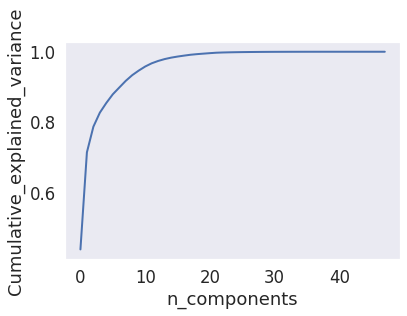

In [62]:
#PCA for dimensionality Reduction
standardized_data.drop(['Close'],axis=1,inplace=True)
pca.n_components = standardized_data.shape[1]
pca_data = pca.fit_transform(standardized_data)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [63]:
# #Reduced Dimension
pca.n_components = 15
pca_data = pca.fit_transform(standardized_data)
pca_df = pd.DataFrame(data=pca_data)
print(pca_df.head())
# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

           0         1          2         3         4         5          6  \
0 -11.359198 -7.904095  13.946173 -4.438212 -5.012568  3.484413  26.618502   
1 -10.794599 -1.495188   4.450124 -3.149418 -3.075754 -0.158085   1.447045   
2 -10.482177 -3.813497   3.451845 -2.941862 -3.047774  0.028922   1.265810   
3 -10.375737 -1.058879   5.244671 -3.083331 -2.693326 -0.376068   1.201752   
4 -10.315964 -0.571228   5.534388 -3.106774 -2.624407 -0.554913   1.081503   

           7          8         9         10        11        12        13  \
0  41.924346  24.422899 -2.724469  10.523996 -0.969213  0.228614  0.796963   
1   2.594543  -3.817285  3.297908  -2.106994  5.066683  4.674679 -2.025386   
2   2.418799  -4.155159  3.367572  -2.414541  4.863577  3.008390 -1.667209   
3   2.362238  -3.886536  3.091713  -2.076294  4.334463  4.486181 -1.707444   
4   2.377355  -3.852892  3.080972  -1.947256  4.202944  4.635571 -1.721184   

         14  
0 -0.123033  
1  1.670715  
2 -0.196825  
3  0.8

In [64]:
pca_final=pca_df.copy()
pca_final['Close']=for_pca['Close']
pca_final.index=for_pca['Date']
print(pca_final.head())

                    0         1          2         3         4         5  \
Date                                                                       
2020-04-01 -11.359198 -7.904095  13.946173 -4.438212 -5.012568  3.484413   
2020-03-31 -10.794599 -1.495188   4.450124 -3.149418 -3.075754 -0.158085   
2020-03-30 -10.482177 -3.813497   3.451845 -2.941862 -3.047774  0.028922   
2020-03-27 -10.375737 -1.058879   5.244671 -3.083331 -2.693326 -0.376068   
2020-03-26 -10.315964 -0.571228   5.534388 -3.106774 -2.624407 -0.554913   

                    6          7          8         9         10        11  \
Date                                                                         
2020-04-01  26.618502  41.924346  24.422899 -2.724469  10.523996 -0.969213   
2020-03-31   1.447045   2.594543  -3.817285  3.297908  -2.106994  5.066683   
2020-03-30   1.265810   2.418799  -4.155159  3.367572  -2.414541  4.863577   
2020-03-27   1.201752   2.362238  -3.886536  3.091713  -2.076294  4.334463   

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe442f2b70>,
      dtype=object)

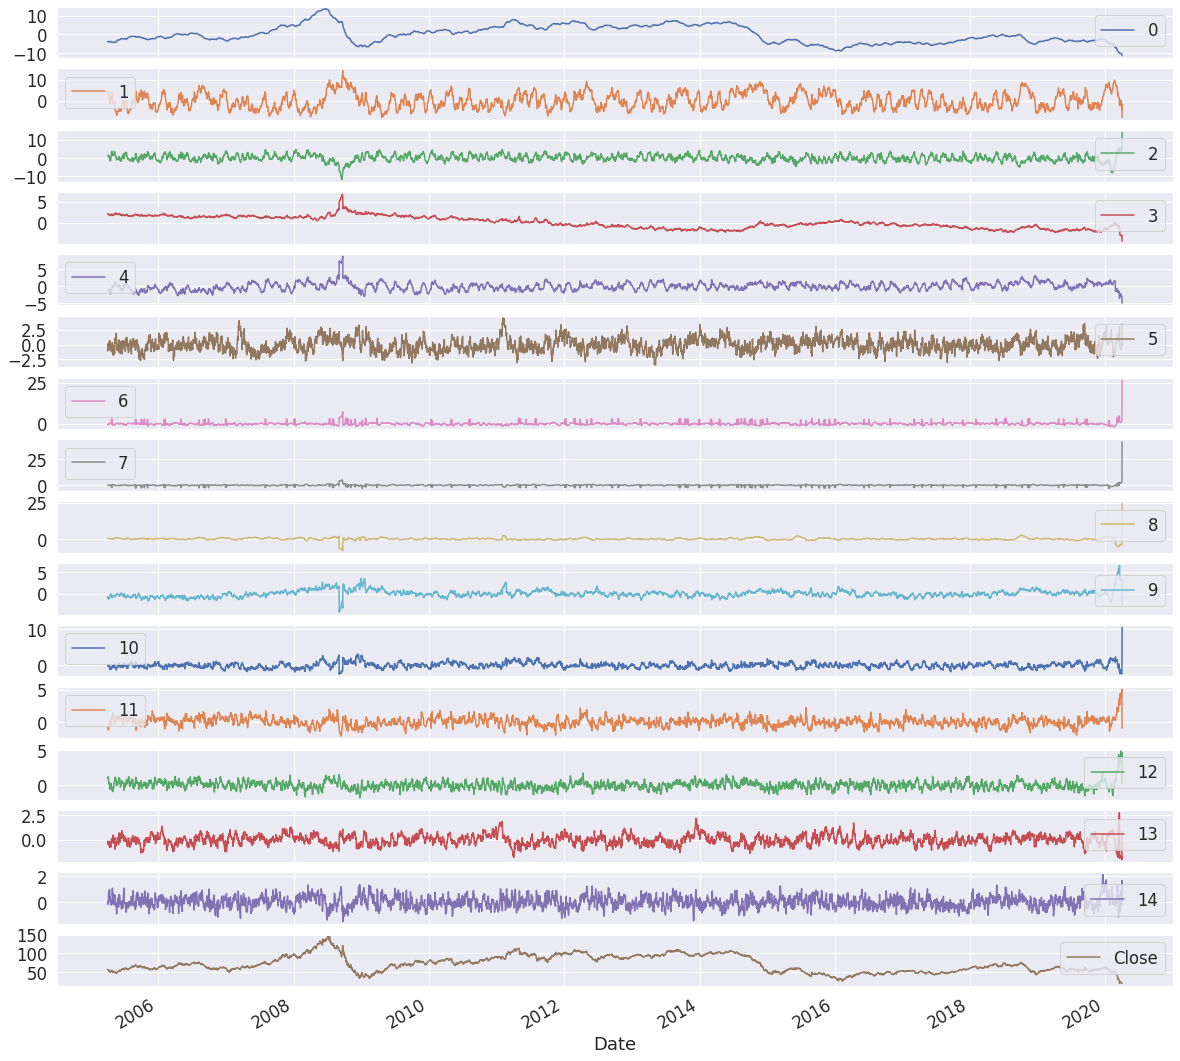

In [65]:
features=pca_final.copy()
features.plot(subplots=True, figsize=(20, 20))

In [66]:
series = features.values
time =features.index.values
split_time = int(series.shape[0] * 0.80)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [67]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[:-1,-1]))
    return ds.batch(batch_size).prefetch(1)

In [68]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [69]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 160
batch_size = 8
shuffle_buffer_size = 1600
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, x_train.shape[1]]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.0050 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=0.0050)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=10, callbacks=[lr_schedule])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

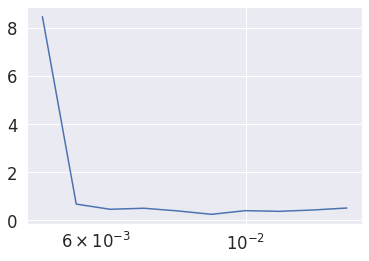

In [70]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [71]:
rnn_forecast = model_forecast(model, series[...], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
closing_price = rnn_forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 

In [72]:
tf.keras.metrics.mean_absolute_error(x_valid[:,-1], closing_price).numpy()

2.358944

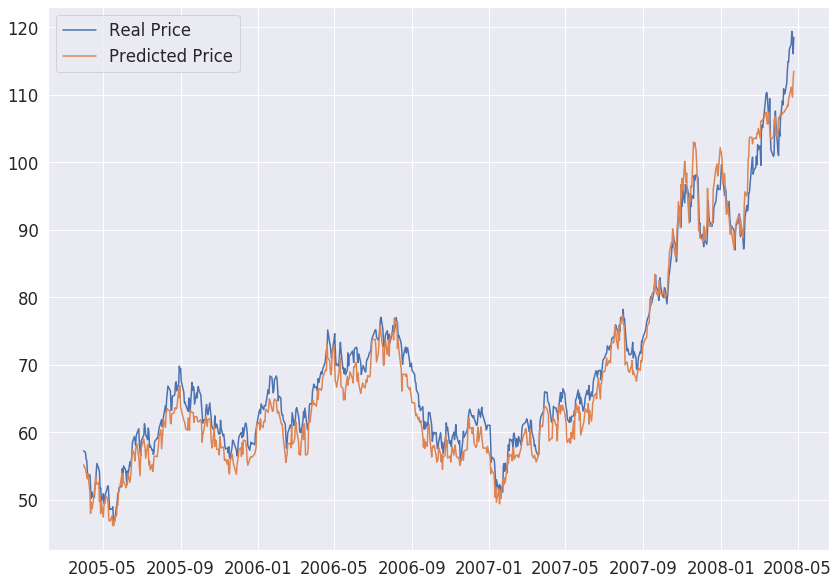

In [73]:
plt.figure(figsize=(14, 10))
plt.plot(time_valid,x_valid[:,-1],label="Real Price")
plt.plot(time_valid,rnn_forecast,label="Predicted Price")
plt.legend(loc="upper left")

In [74]:
prediction=pd.DataFrame()
prediction['Predicted_Price']=np.around(rnn_forecast.tolist(),decimals=2)
prediction['Real_Price']=x_valid[:,-1].tolist()
print(prediction.tail())
prediction.to_csv('./PredVsReal.csv')

     Predicted_Price  Real_Price
766            53.12       54.11
767            53.54       55.85
768            54.10       56.04
769            54.52       57.01
770            55.18       57.27


<Figure size 432x288 with 0 Axes>

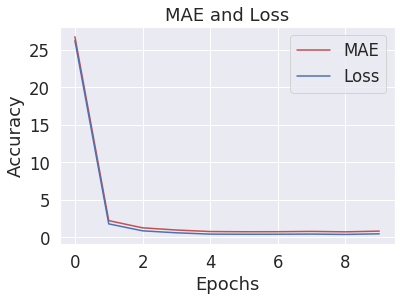

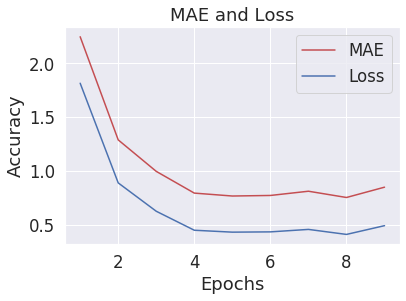

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[1:]
mae_zoom = mae[1:]
loss_zoom = loss[1:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()